# Explain the Best Model
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import scored data
* Use Shapley Value to explain the model

# 1. Parameters

In [1]:
#Name
ModelName = 'titanic_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'PassengerId'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1


#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'NameTitle'
,'Sex']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean']
selected_features = CAT + NUM

# 2. Import Libraries

In [2]:
# !pip -q install -r requirements.txt

In [3]:
try:
    import sys
    sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')
except:
    pass

In [4]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import h2o
import seaborn as sns
import altair as alt

# 3. Importing Scored Data for Explain Modeling

In [5]:
datascored_df_full = pd.read_csv('./titanic/df_cluster.csv')

In [6]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    datascored_df = datascored_df_full.copy()
else:
    datascored_df = datascored_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del datascored_df_full

In [7]:
#List all dummies and normalized variables
normalized_and_dummy = []
for i in datascored_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)
# normalized_and_dummy

In [8]:
#Numeric features must be float type
for col_name in (NUM + normalized_and_dummy):
    datascored_df[col_name] = datascored_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    datascored_df[col_name] = datascored_df[col_name].astype(str)

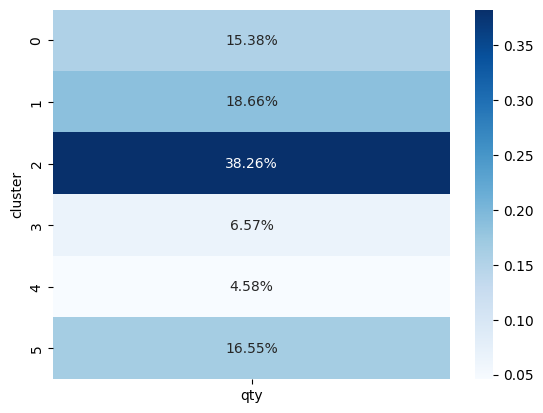

In [9]:
df_cluster_plot = datascored_df.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
# sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
# plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 4. Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

## 4.1 For calculating the shapley value, we need to create a multiclass classification model using the clusters as the target featrure

In [10]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  --------------------------------
H2O_cluster_uptime:         20 mins 02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.3
H2O_cluster_version_age:    4 months and 24 days !!!
H2O_cluster_name:           H2O_from_python_azureuser_nw95hh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    977 Mb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.5 final
--------------------------  --------------------------------

In [11]:
#Setting the model target variable name
VarTarget = 'cluster'

#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(datascored_df.loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 770
Validation: 82


In [12]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'rmse'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
#                    distribution="multinomial",
#                    auc_type="MACRO_OVR",
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
17:52:27.750: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████
17:52:41.264: GLM_1_AutoML_2_20221202_175227 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 34 out of bounds for length 34

████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:03.120116



In [13]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id rmse mean_per_class_error logloss mse 
 
 
 GBM_1_AutoML_2_20221202_175227 0.300537 0.168568 0.352078 0.0903227 
 StackedEnsemble_BestOfFamily_1_AutoML_2_20221202_175227 0.324608 0.31408 0.417459 0.10537 
 DRF_1_AutoML_2_20221202_175227 0.327438 0.257457 1.85931 0.107216 
 GBM_3_AutoML_2_20221202_175227 0.357877 0.21579 0.445106 0.128076 
 XGBoost_1_AutoML_2_20221202_175227 0.370404 0.388012 0.443677 0.137199 
 GBM_4_AutoML_2_20221202_175227 0.378026 0.271345 0.487608 0.142904 
 GBM_2_AutoML_2_20221202_175227 0.397961 0.313012 0.521297 0.158373 
 XGBoost_2_AutoML_2_20221202_175227 0.545033 0.435234 0.83118 0.297061 
 StackedEnsemble_BestOfFamily_2_AutoML_2_20221202_175227 0.724152 0.833333 1.39712 0.524397 
 StackedEnsemble_AllModels_1_AutoML_2_20221202_175227 0.734699 0.833333 1.43629 0.539782

In [14]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_2_20221202_175227


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               72.0                     432.0              49691.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        2.0        4.0    3.159722         3.0         5.0     4.476852



ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.04034518838139896
RMSE: 0.20086111714664678
LogLoss: 0.13406832750374006
Mean Per-Class Error: 0.11129620463293231
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0      1      2     3     4      5     Error      Rate
0  114.0    0.0    0.0   3.0   2.0    0.0  0.042017   5 / 119
1    0.0  138.0    0.0   0.0   1.0    0.0  0.007194   1 / 139
2    0.0    0.0  297.0   0.0   0.0    0.0  0.000000   0 / 297
3   10.0    8.0    0.0  33.0   0.0    0.0  0.352941   18 / 51
4    7.0    2.0    0.0   0.0  27.0    0.0  0.250000    9 / 36
5    0.0    0.0    0.0   2.0   0.0  126.0  0.015625   2 / 128
6  131.0  148.0  297.0  38.0  30.0  126.0  0.045455  35 / 770


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.954545
1  2   0.998701
2  3   1.000000
3  4   1.000000
4  5   1.000000
5  6   1.000000


ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.09032266495295853
RMSE: 0.30053729378058647
LogLoss: 0.35207765956347925
Mean Per-Class Error: 0.16856763925729443
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0     1     2    3    4     5     Error    Rate
0  10.0   0.0   0.0  1.0  1.0   0.0  0.166667  2 / 12
1   0.0  20.0   0.0  0.0  0.0   0.0  0.000000  0 / 20
2   0.0   0.0  28.0  0.0  1.0   0.0  0.034483  1 / 29
3   0.0   1.0   0.0  3.0  0.0   1.0  0.400000   2 / 5
4   1.0   0.0   0.0  0.0  2.0   0.0  0.333333   1 / 3
5   0.0   0.0   0.0  1.0  0.0  12.0  0.076923  1 / 13
6  11.0  21.0  28.0  5.0  4.0  13.0  0.085366  7 / 82


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.914634
1  2   0.987805
2  3   0.987805
3  4   0.987805
4  5   1.000000
5  6   1.000000


ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.06840514866326872
RMSE: 0.2615437796302346
LogLoss: 0.22382320289472057
Mean Per-Class Error: 0.1984534133897364
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0      1      2     3     4      5     Error      Rate
0  108.0    0.0    1.0   3.0   7.0    0.0  0.092437  11 / 119
1    0.0  137.0    0.0   1.0   1.0    0.0  0.014388   2 / 139
2    0.0    0.0  297.0   0.0   0.0    0.0  0.000000   0 / 297
3   17.0   11.0    0.0  21.0   0.0    2.0  0.588235   30 / 51
4   14.0    3.0    0.0   0.0  19.0    0.0  0.472222   17 / 36
5    0.0    1.0    0.0   2.0   0.0  125.0  0.023438   3 / 128
6  139.0  152.0  298.0  27.0  27.0  127.0  0.081818  63 / 770


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.918182
1  2   0.993506
2  3   0.997403
3  4   1.000000
4  5   1.000000
5  6   1.000000


Cross-Validation Metrics Summary: 


mean        sd  cv_1_valid  cv_2_valid  \
0                  accuracy   0.918182  0.016933    0.902597    0.902597   
1                       auc        NaN  0.000000         NaN         NaN   
2                       err   0.081818  0.016933    0.097403    0.097403   
3                 err_count  12.600000  2.607681   15.000000   15.000000   
4                   logloss   0.223686  0.054984    0.256779    0.298546   
5       max_per_class_error   0.660000  0.166812    0.625000    0.833333   
6   mean_per_class_accuracy   0.802050  0.032617    0.800137    0.757778   
7      mean_per_class_error   0.197950  0.032617    0.199863    0.242222   
8                       mse   0.068586  0.017035    0.086295    0.086039   
9                    pr_auc        NaN  0.000000         NaN         NaN   
10                       r2   0.972916  0.004460    0.968049    0.969025   
11                     rmse   0.260248  0.032720    0.293760    0.293325   

    cv_3_valid  cv_4_valid  cv_5_valid  
0     0.928571    0.915584    0.941558  
1          NaN         NaN         NaN  
2     0.071429    0.084416    0.058442  
3    11.000000   13.000000    9.000000  
4     0.202699    0.204407    0.156000  
5     0.625000    0.416667    0.800000  
6     0.832317    0.835000    0.785017  
7     0.167683    0.165000    0.214983  
8     0.058323    0.064111    0.048160  
9          NaN         NaN         NaN  
10    0.977396    0.972656    0.977453  
11    0.241501    0.253202    0.219453


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-12-02 17:52:49   7.927 sec              0.0       0.833333   
1     2022-12-02 17:52:49   8.059 sec              5.0       0.609007   
2     2022-12-02 17:52:49   8.154 sec             10.0       0.476063   
3     2022-12-02 17:52:49   8.278 sec             15.0       0.383543   
4     2022-12-02 17:52:49   8.401 sec             20.0       0.332248   
5     2022-12-02 17:52:49   8.491 sec             25.0       0.302135   
6     2022-12-02 17:52:49   8.615 sec             30.0       0.280629   
7     2022-12-02 17:52:49   8.711 sec             35.0       0.264136   
8     2022-12-02 17:52:50   8.798 sec             40.0       0.251447   
9     2022-12-02 17:52:50   8.923 sec             45.0       0.239736   
10    2022-12-02 17:52:50   9.037 sec             50.0       0.229830   
11    2022-12-02 17:52:50   9.185 sec             55.0       0.221004   
12    2022-12-02 17:52:50   9.324 sec             60.0       0.212919   
13    2022-12-02 17:52:50   9.430 sec             65.0       0.208326   
14    2022-12-02 17:52:50   9.537 sec             70.0       0.202917   
15    2022-12-02 17:52:50   9.584 sec             72.0       0.200861   

    training_logloss  training_classification_error  training_auc  \
0           1.791759                       0.775325           NaN   
1           0.971381                       0.118182           NaN   
2           0.663152                       0.097403           NaN   
3           0.470930                       0.103896           NaN   
4           0.364334                       0.105195           NaN   
5           0.302802                       0.100000           NaN   
6           0.258006                       0.090909           NaN   
7           0.227117                       0.084416           NaN   
8           0.204522                       0.077922           NaN   
9           0.185574                       0.074026           NaN   
10          0.171955                       0.067532           NaN   
11          0.159889                       0.059740           NaN   
12          0.149908                       0.051948           NaN   
13          0.143169                       0.053247           NaN   
14          0.136613                       0.048052           NaN   
15          0.134068                       0.045455           NaN   

    training_pr_auc  validation_rmse  validation_logloss  \
0               NaN         0.833333            1.791759   
1               NaN         0.628965            1.032340   
2               NaN         0.512490            0.750469   
3               NaN         0.435244            0.582637   
4               NaN         0.394951            0.494097   
5               NaN         0.371179            0.445665   
6               NaN         0.358399            0.417655   
7               NaN         0.346538            0.394510   
8               NaN         0.336653            0.377239   
9               NaN         0.330336            0.371246   
10              NaN         0.322276            0.360619   
11              NaN         0.314901            0.354381   
12              NaN         0.304630            0.339899   
13              NaN         0.303067            0.345516   
14              NaN         0.301717            0.353291   
15              NaN         0.300537            0.352078   

    validation_classification_error  validation_auc  validation_pr_auc  
0                          0.804878             NaN                NaN  
1                          0.170732             NaN                NaN  
2                          0.146341             NaN                NaN  
3                          0.146341             NaN                NaN  
4                          0.146341             NaN                NaN  
5                          0.134146             NaN                NaN  
6                          0.121951             NaN                N


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0         Pclass           706.403320           1.000000    0.385394
1  cabine_prefix           329.873291           0.466976    0.179970
2      NameTitle           315.169464           0.446161    0.171948
3           Fare           227.657654           0.322277    0.124204
4            Sex           189.163300           0.267784    0.103202
5       Embarked            49.796696           0.070493    0.027168
6       Age_Mean            11.826560           0.016742    0.006452
7          SibSp             2.484368           0.003517    0.001355
8          Parch             0.562546           0.000796    0.000307

In [15]:
h2o_predict = best_AutoML.predict(data_hdf)
df_predict = h2o_predict.cbind(data_hdf).as_data_frame()
df_predict

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict        p0        p1        p2        p3        p4        p5  \
0          2  0.000191  0.000613  0.998963  0.000039  0.000033  0.000162   
1          3  0.460726  0.000357  0.000131  0.516862  0.018415  0.003509   
2          0  0.870968  0.002585  0.000142  0.117950  0.001150  0.007206   
3          2  0.000080  0.000362  0.999188  0.000067  0.000091  0.000212   
4          2  0.000103  0.000092  0.999489  0.000032  0.000107  0.000177   
..       ...       ...       ...       ...       ...       ...       ...   
847        1  0.000255  0.997645  0.000047  0.000851  0.001093  0.000107   
848        0  0.852553  0.003056  0.000109  0.123916  0.000786  0.019580   
849        5  0.001172  0.001206  0.002376  0.003728  0.000268  0.991250   
850        0  0.692269  0.001468  0.001530  0.015964  0.288188  0.000581   
851        2  0.000106  0.000296  0.999301  0.000029  0.000072  0.000198   

     Pclass Embarked cabine_prefix NameTitle     Sex     Fare  SibSp  Parch  \
0         3        S       missing        Mr    male   7.2500      1      0   
1         1        C             C       Mrs  female  71.2833      1      0   
2         1        S             C       Mrs  female  53.1000      1      0   
3         3        S       missing        Mr    male   8.0500      0      0   
4         3        Q       missing        Mr    male   8.4583      0      0   
..      ...      ...           ...       ...     ...      ...    ...    ...   
847       2        S       missing       LOW    male  13.0000      0      0   
848       1        S             B      Miss  female  30.0000      0      0   
849       3        S       missing      Miss  female  23.4500      1      2   
850       1        C             C        Mr    male  30.0000      0      0   
851       3        Q       missing        Mr    male   7.7500      0      0   

      Age_Mean  cluster  
0    22.000000        2  
1    38.000000        3  
2    35.000000        0  
3    35.000000        2  
4    29.699118        2  
..         ...      ...  
847  27.000000        1  
848  19.000000        0  
849  29.699118        5  
850  26.000000        0  
851  32.000000        2  

[852 rows x 17 columns]

In [16]:
#Funcao para calcular o valor de shapley
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names, NUM, CAT):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
        self.NUM = NUM
        self.CAT = CAT
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)

        #Numeric features must be float type
        for col_name in self.NUM:
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)

        #Categorical features must be string type and null values will be filled with "Missing"
        for col_name in self.CAT:        
            self.dataframe = self.dataframe.astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'Missing'})

        self.predictions = h2o.mojo_predict_pandas(self.dataframe.set_index(self.feature_names[0], inplace=False), mojo_zip_path=self.h2o_model, verbose=False)
        return self.predictions.drop(columns='predict').astype('float64').values

In [17]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = df_predict.loc[:,(selected_features)].sample(n=30, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [18]:
path_model_mojo = best_AutoML.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
path_model_mojo

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/fiep-cpu1/code/Users/maxreis86/FIEP-Machine-Learning-e-Computacao-em-Nuvem/aula_02_titanic_kmeans/output_model/models/best/GBM_1_AutoML_2_20221202_175227.zip'

In [19]:
h2o_wrapper = H2oProbWrapper(path_model_mojo, selected_features, NUM, CAT)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

  0%|          | 0/30 [00:00<?, ?it/s]

## 4.1 Main SHAP Graphics

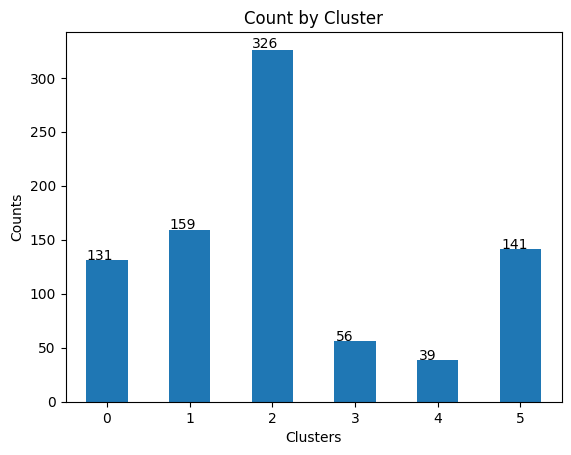

In [20]:
ax = df_predict.reset_index().groupby('cluster').agg('index').count().plot(kind='bar', stacked=False, ylabel='Counts', xlabel='Clusters',
             title='Count by Cluster', rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

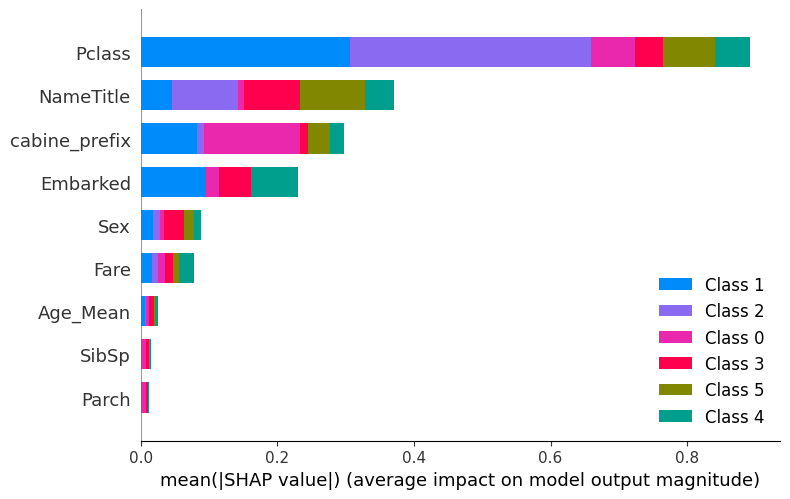

None

In [21]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

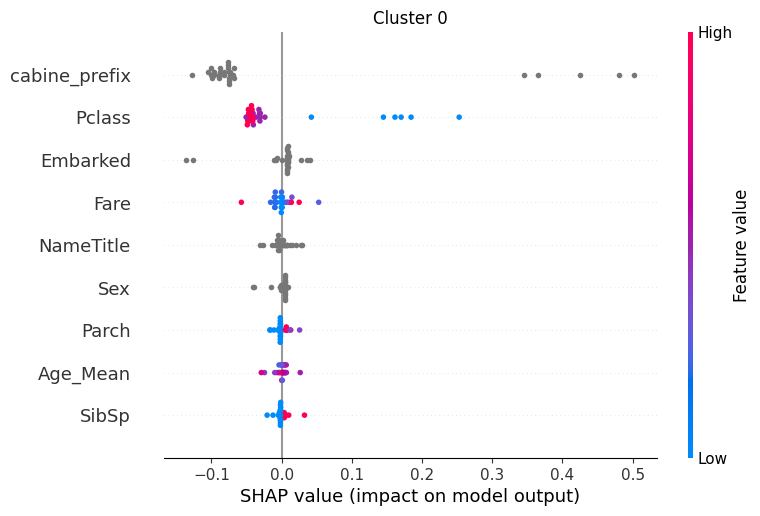

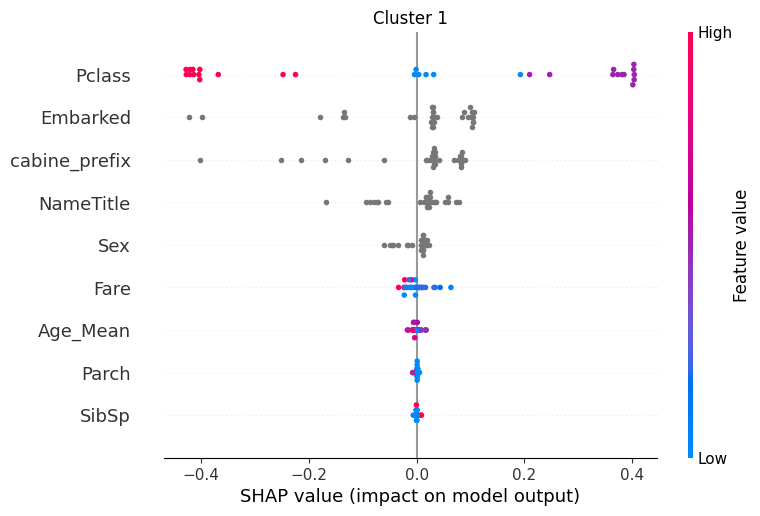

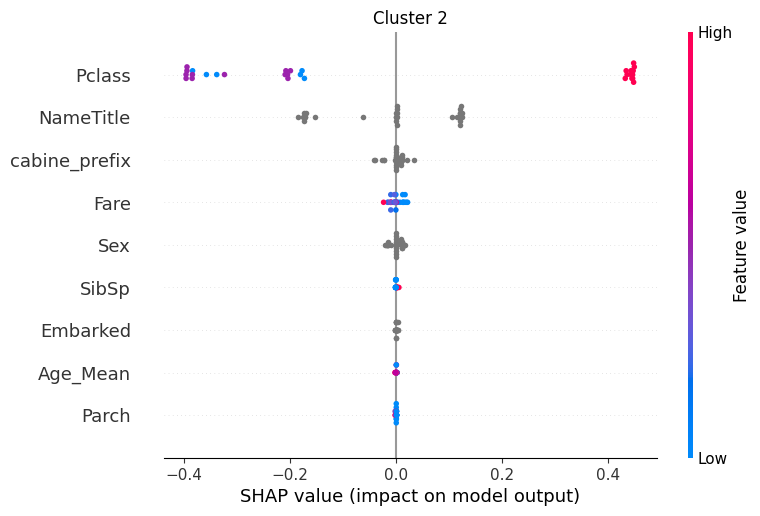

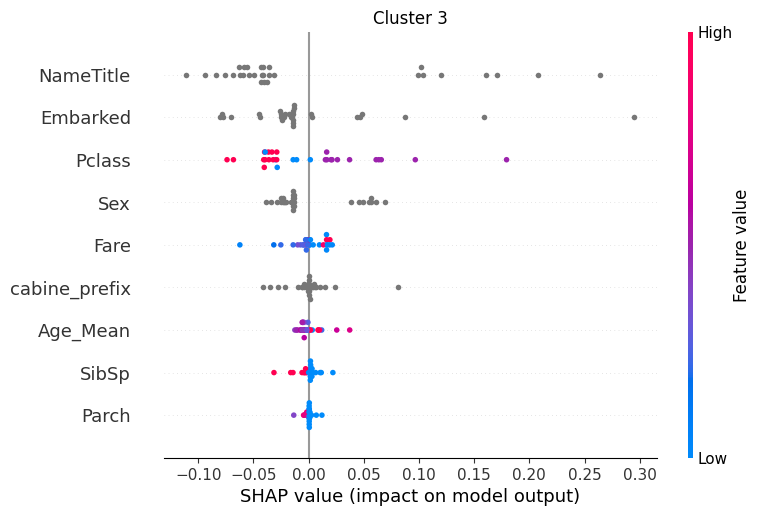

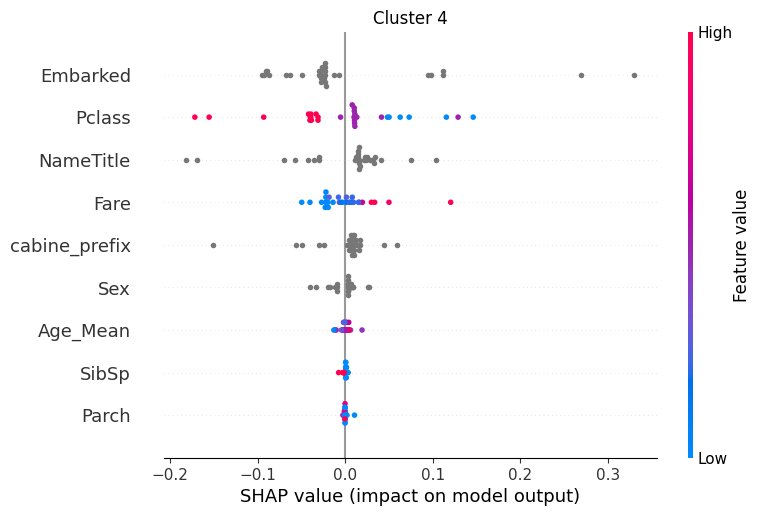

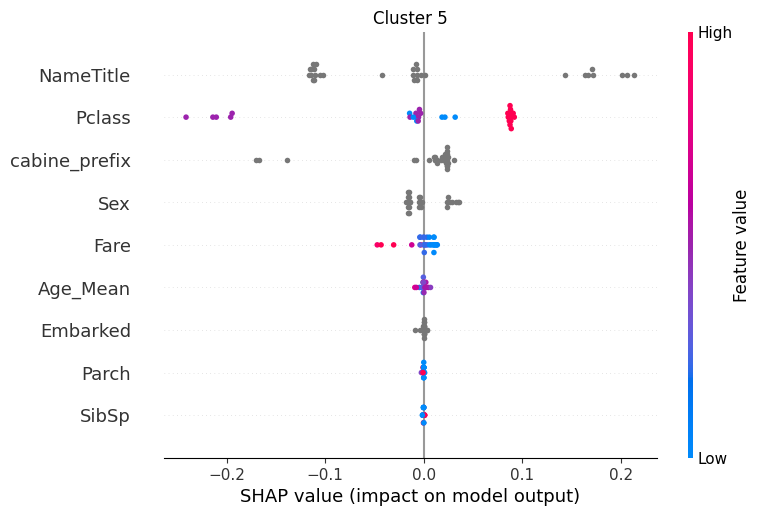

In [22]:
for cnr in range(len(df_predict['cluster'].unique())):
    shap.summary_plot(h2o_shap_values[cnr], shap_sample[selected_features], max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()

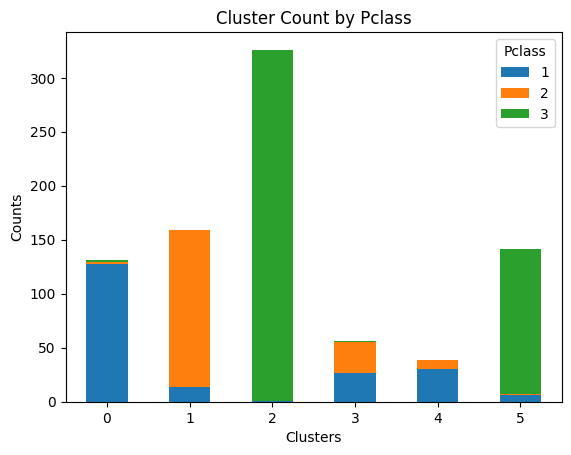

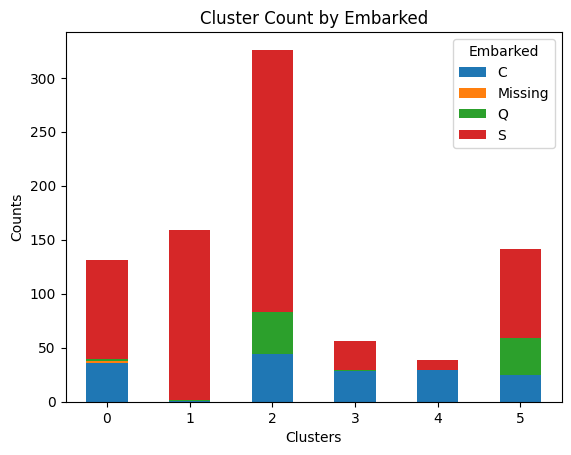

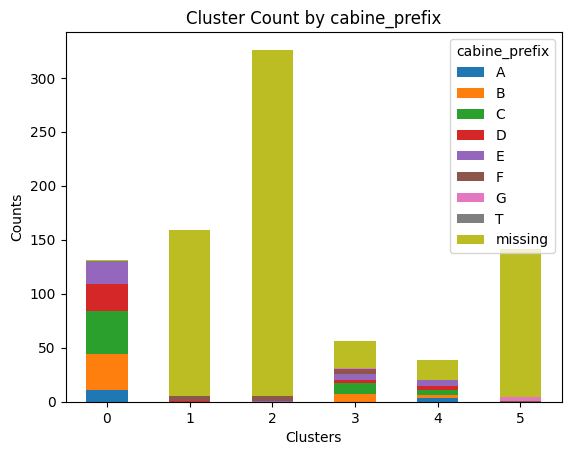

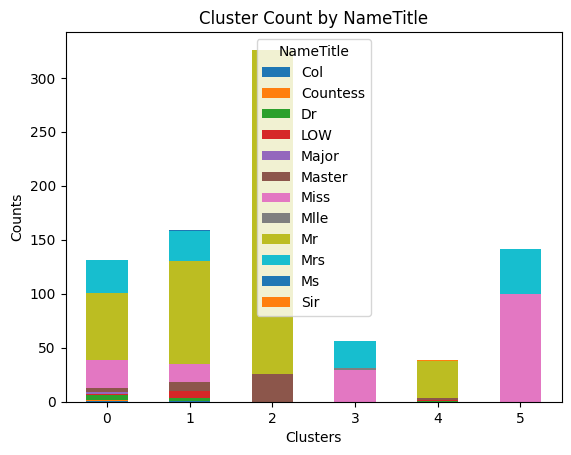

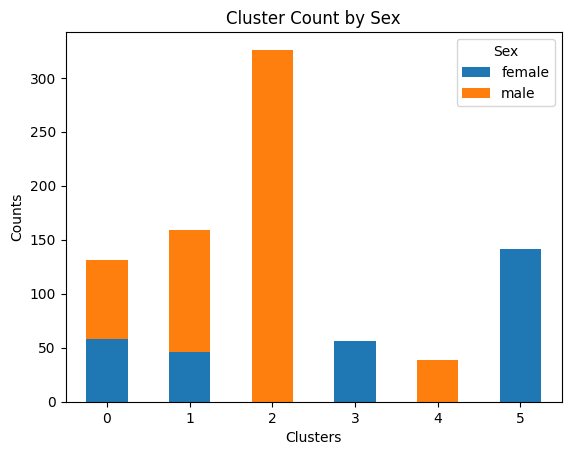

In [23]:
for i in CAT:
    # create a pivot table
    dfp = df_predict[[i,'cluster']].pivot_table(index='cluster', columns=[i], aggfunc=len)

    # plot the dataframe
    dfp.plot(kind='bar', stacked=True, ylabel='Counts', xlabel='Clusters',
             title=f'Cluster Count by {i}', rot=0)

In [24]:
def plot_comparison(data, feature):
    print(feature)
    cluster_qty = len(data['cluster'].unique())

    fig, ax = plt.subplots(cluster_qty, 1, sharex=True, constrained_layout=True, figsize=(15,cluster_qty))
    fig.suptitle(f'Feature {feature}', fontsize=16)

    for j in range(cluster_qty):
        sns.violinplot(x=data.query(f'cluster == {j}')[i].rename(""), ax=ax[j])
        ax[j].set_title('Cluster ' + str(j))
    plt.show()
    plt.close()

Fare


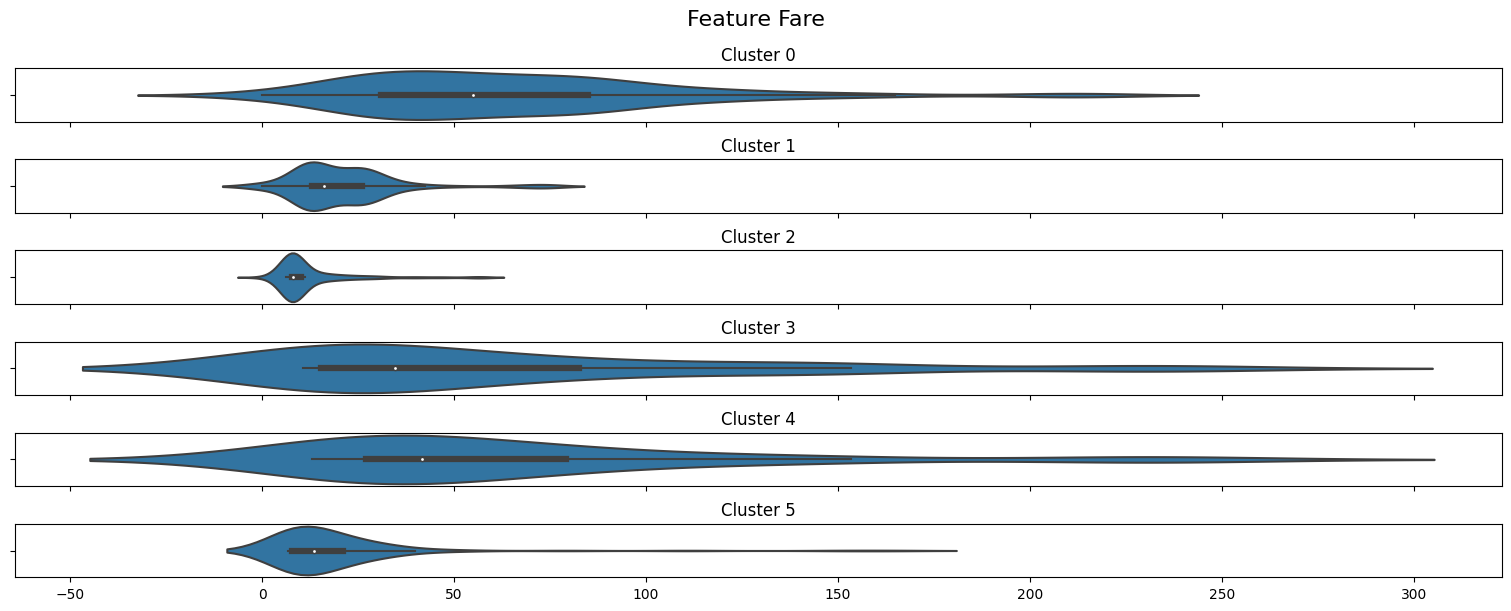

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

SibSp


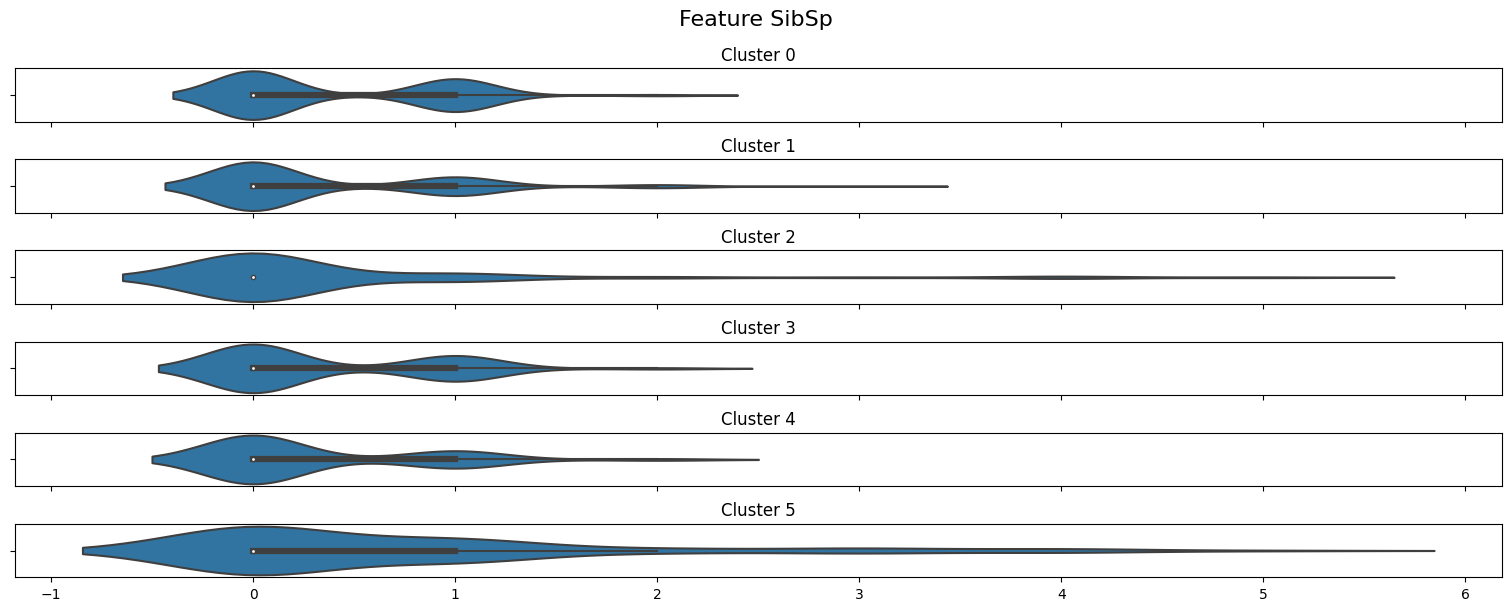

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

Parch


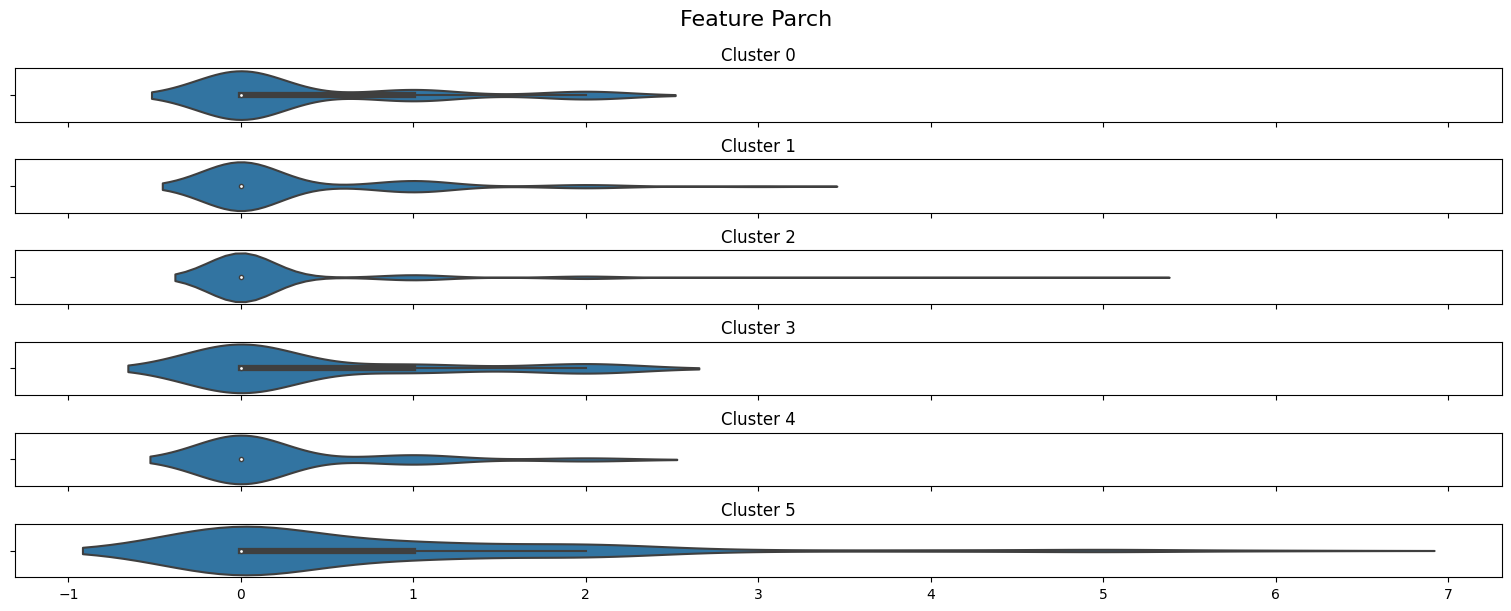

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

Age_Mean


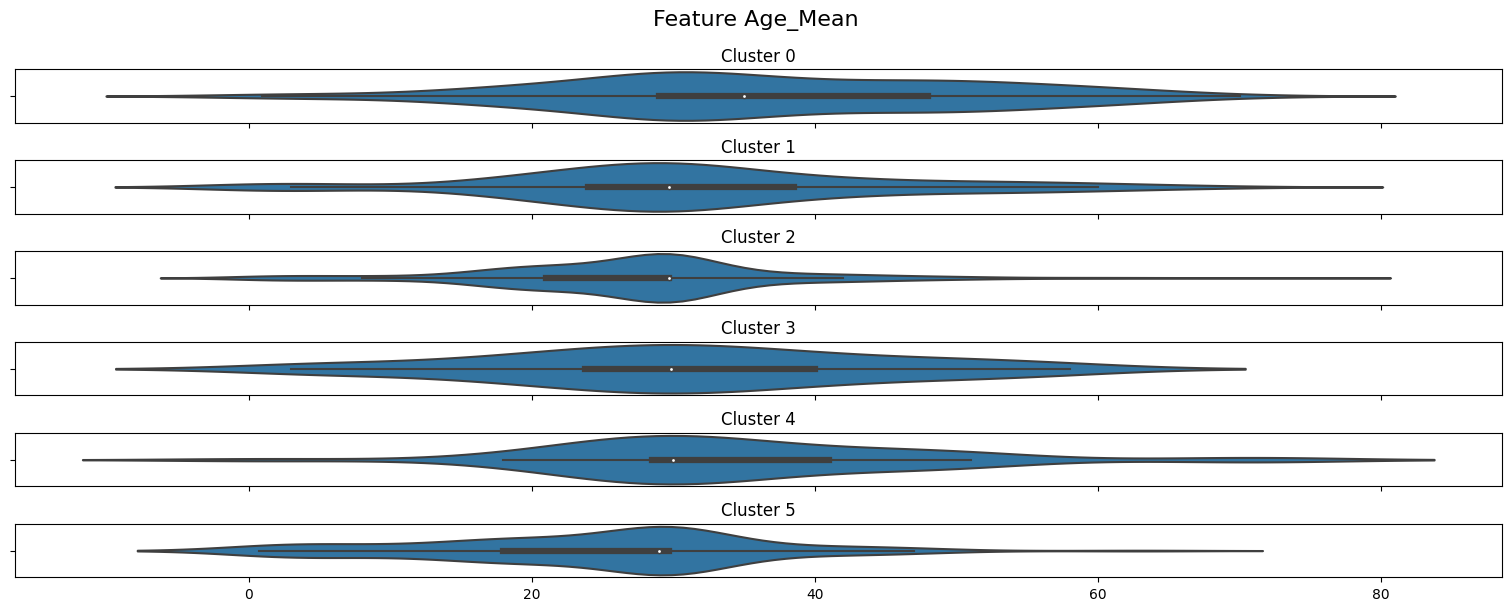

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

In [25]:
for i in NUM:
    plot_comparison(df_predict[[i]+['cluster']], i)
    
    cluster_qty = len(df_predict['cluster'].unique())
    for j in NUM:
        if i!=j:
            display(alt.Chart(df_predict).mark_point().encode(x=str(j)+':Q', y=str(i)+':Q', color='cluster:N', tooltip=selected_features).interactive().properties(
                    width=180,
                    height=180
                    ).facet(
                    facet='cluster:N',
                    columns=cluster_qty
                    ).resolve_axis(
                    x='independent',
                    y='independent',
                    ))